## Goals: Training the *Final* Models

This notebook trains the model on the full *baseline_dataset* for the final prediction on evaluation data.

Here, we train a model designed to generalize across water stations in Brazil and France. However, you are not required to follow this approach and may opt to train separate models for different geographic *regions*.

This baseline model training example utilizes all available features, with hyperparameters chosen for quick execution rather than optimization. For hyperparameter tuning and feature selection explorations, refer to the `02_exploration` folder.

> **Note:** This notebook requires outputs from the `00 Preprocessing` notebooks.

<img src="../images/notebook-3.png" alt="Experiment Diagram" style="width:75%; text-align:center;" />

### 1. Data Import and Setup

This section imports the necessary libraries, sets up environment paths, and includes custom utility functions.

In [2]:
import os
import sys

import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
import lightgbm as lgb

from interpret.glassbox import ExplainableBoostingRegressor
from mapie.regression import MapieQuantileRegressor
from quantile_forest import RandomForestQuantileRegressor

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

from src.utils.model import split_dataset, compare_models_per_station, create_deep_model

##### Constants :
- **INPUT_DIR**: Directory for input data (same as in "02 - Feature Engineering").
- **MODEL_DIR**: Directory where trained models are saved.
- **DATASET_DIR**: Directory where the Zenodo dataset is unzipped.

##### Model Parameters

- **SEED**: 42 (for reproducibility)
- **NUMBER_OF_WEEK**: 4 (one model is trained per week)

##### FINAL_MODELS

- **mapie**: Combines LightGBM with MAPIE. **MAPIE** (Model Agnostic Prediction Interval Estimator) computes prediction intervals for any regression model using conformal methods.
- **qrf**: Quantile Random Forest (natively produces prediction intervals)
- **ebm**: Explainable Boosting Machine is used as a exemple that does not natively implement prediction intervals, but that can be customised to do so.

In [ ]:
INPUT_DIR = "../../../data/input/"
DATASET_DIR = "../../../dataset/"
DATASET_TRANSFORMS = [
    "rm_gnv_st",
    "pca",
    "snow_index",
    "oh_enc_date",
    "scl_wtr_flows",
    "scl_catch"
]

DATASET_SPEC = "_".join(DATASET_TRANSFORMS)

MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4 # Number of weeks to predict one model is trained per week

FINAL_MODELS = [
                "mapie",
                "qrf",
                # "lgbm",
                # "ebm",
                # "deep_ensemble",
                ]
mapie_enbpi = {}
mapie = {}
qrf = {}
lgbm = {}
mapie_aci = {}

COLUMNS_TO_DROP = ["water_flow_week1", "water_flow_week2", "water_flow_week3", "water_flow_week4"]


### 2. Data Loading
Load in the baseline datasets, create the directory to save models.

In [4]:
dataset_train = pd.read_csv(f"{INPUT_DIR}dataset_{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

Data pre-processing removal of unnecessary columns, setup of the target

In [5]:
X_train = dataset_train.drop(columns=COLUMNS_TO_DROP)
y_train = {}
for i in range(0, NUMBER_OF_WEEK):
    y_train[i] = dataset_train[f"water_flow_week{i+1}"]


### 2. Models training
#### a. LGBM + MAPIE

## Mapie Model Training Overview

- **Configuration:**  
  - Sets `ALPHA` (0.1) as the prediction interval level.
  - Defines `TIME_VALIDATION` as a split point for creating a validation set.
  - Configures LightGBM parameters (`LGBM_PARAMS`) for quantile regression.




In [6]:
ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

LGBM_PARAMS = {
    "max_depth": 15,
    "learning_rate": 0.01,
    "n_estimators": 500,
    "colsample_bytree": 0.7,
    "objective": "quantile",
    "alpha": ALPHA
}

- **Data Preparation:**  
  - Splits `dataset_train` into training and validation subsets using `split_dataset`.
  - Removes unnecessary columns from both the training and validation datasets.
  - Extracts target variables for each week (from `water_flow_week1` to `water_flow_week4`).

- **Model Training:**  
  For each week:
  - Initializes a LightGBM regressor with the specified parameters.
  - Wraps it in a `MapieQuantileRegressor` to estimate prediction intervals.
  - Trains the model on the training data and calibrates it using the validation data.
  - Saves the trained model 

In [7]:
if "mapie" in FINAL_MODELS: 
    print("Training Mapie")


    train_mapie, val_mapie, val_temporal  = split_dataset(dataset_train, 0.75, TIME_VALIDATION)    

    X_train_mapie = train_mapie.drop(columns=COLUMNS_TO_DROP)
    X_train_mapie = X_train_mapie.drop(columns=["station_code"])
    print(len(X_train_mapie.columns))
    y_train_mapie = {}
    for i in range(0, NUMBER_OF_WEEK):
        y_train_mapie[i] = train_mapie[f"water_flow_week{i+1}"]

    X_val = val_mapie.drop(columns=COLUMNS_TO_DROP)
    X_val = X_val.drop(columns=["station_code"])
    y_val = {}
    y_val[0] = val_mapie["water_flow_week1"]
    for i in range(1, NUMBER_OF_WEEK):
        y_val[i] = val_mapie[f"water_flow_week{i+1}"]

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Initialize and train MapieQuantileRegressor
        regressor = lgb.LGBMRegressor(**LGBM_PARAMS)
        mapie[i] = MapieQuantileRegressor(estimator=regressor, method="quantile", cv="split", alpha=ALPHA)
        mapie[i].fit(X_train_mapie, y_train_mapie[i], X_calib=X_val, y_calib=y_val[i])
        
        # save model with date
        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

        model_path = f"{MODEL_DIR}final/mapie_quantile_{time}_week_{i}.pkl"
        joblib.dump(mapie[i], model_path)


Training Mapie
43
Training week 0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3478
[LightGBM] [Info] Number of data points in the train set: 14532, number of used features: 43
[LightGBM] [Info] Start training from score 0.172857
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3478
[LightGBM] [Info] Number of data points in the train set: 14532, number of used features: 43
[LightGBM] [Info] Start training from score 522.960693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

#### b. QRF

- **Training:**  
  Initializes a `RandomForestQuantileRegressor` with the following parameters:
  - 100 estimators
  - Maximum depth of 10
  - Minimum of 10 samples per leaf

  These parameters allow for relatively fast training, though they are not optimized for peak performance. 
  
  The model is then fitted using `X_train` and the corresponding weekly target `y_train[i]`.

In [ ]:
X_train_qrf = X_train.drop(columns=["station_code"])

if "qrf" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Train RandomForestQuantileRegressor

        # n_estimators= 55, min_samples_split= 20, min_samples_leaf= 11, max_features= None, max_depth= 23, bootstrap= True

        qrf[i] = RandomForestQuantileRegressor(n_estimators= 55, min_samples_split= 20, min_samples_leaf= 11, max_features= None, max_depth= 23, bootstrap= True, random_state=SEED)
        qrf[i].fit(X_train_qrf, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf[i], model_path)

Training week 0
Training week 1
Training week 2
Training week 3


##### b.1 LGBM


In [9]:
X_train_lgbm = X_train.drop(columns=["station_code"])

quantiles = [0.05, 0.5, 0.95]

if "lgbm" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        lgbm[i] = {}
        # Train LGBMRegressor
        for q in quantiles:
            print(f"Training quantiles {q}")
            lgbm[i][q] = lgb.LGBMRegressor(
                objective="quantile",
                alpha=q,
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1
            )
            lgbm[i][q].fit(X_train_lgbm, y_train[i])
            time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
            model_path = f"{MODEL_DIR}final/lgbm_quantile_q{q}_{time}_week_{i}.pkl"
            joblib.dump(lgbm[i][q], model_path)

#### c. Explainable Boosting Machine

EBM is an ensemble method that does not natively provide access to its individual members for performing quantile predictions or generating prediction intervals. To overcome this limitation, we manually construct an ensemble.


- **Ensemble Training:**  
- For each ensemble member (seed from 0 to `#NUM_ENSEMBLES`):
    - A bootstrap sample is created from `X_train` and `y_train[i]` using sampling with replacement.
    - An `ExplainableBoostingRegressor` is instantiated with fixed parameters (e.g., `max_bins=128`, `learning_rate=0.05`, `interactions=3`, and `random_state=42` to ensure consistent binning) and then trained on the sampled data.
    - The trained model is appended to the list for the current week.
- **Saving the Ensemble:**  
- The ensemble (i.e., the list of EBM models for the week) is saved.

In [10]:
if "ebm" in FINAL_MODELS:
    NUM_ENSEMBLES = 10
    ebm_ensembles = {}
    for i in range(NUMBER_OF_WEEK):
        print(f"Training EBM ensemble for week {i}")

        models_i = []
        for seed in range(NUM_ENSEMBLES):
            print(f"Training EBM ensemble {seed} for week {i}")
            # 1. Create your bootstrap sample or subset (if you want bagging)
            sample_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
            X_sample = X_train.iloc[sample_indices]
            y_sample = y_train[i][sample_indices]
            
            # 2. Train an EBM with consistent binning parameters
            ebm_model = ExplainableBoostingRegressor(
                outer_bags=1,
                inner_bags=1,
                max_bins=128,
                learning_rate=0.05,
                interactions=3,
                early_stopping_rounds=100,
                random_state=SEED
            )
            ebm_model.fit(X_sample, y_sample)
            
            models_i.append(ebm_model)

        ebm_ensembles[i] = models_i
        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/ebm_ensemble_{time}_week_{i}.pkl"

        joblib.dump(ebm_ensembles[i], file_path)
        print(f"Saved EBM ensembles to {file_path}")

#### d. Deep Ensemble
The Deep Ensemble is a quantile regression on an ensemble of models. We train one ensemble per week to predict the water flow for that week. The models are trained using the same hyperparameters, except seeds and .

- **Ensemble Training:** 
- For each ensemble member (seed from 0 to 4):
    - Create a bootstrap sample of the training data.
    - Train a quantile regression model using the same hyperparameters as the individual models in the ensemble.
- Save the ensemble to a file.


In [11]:
station_codes = X_train["station_code"].unique()
if "deep_ensemble" in FINAL_MODELS:
    NUM_ENSEMBLES = 15
    deep_ensembles = {}

    for i in range(NUMBER_OF_WEEK):
        print(f"Training deep ensemble for week {i}")
        models_i = []
        
        for seed in range(NUM_ENSEMBLES):
            print(f"Training deep ensemble model {seed} for week {i}")
            
            selected_station_codes = np.random.choice(station_codes, size=len(station_codes)-3, replace=False)
            sample_indices = X_train["station_code"].isin(selected_station_codes)
            X_sample = X_train[sample_indices]
            y_sample = y_train[i][sample_indices]
            tf.random.set_seed(seed*SEED)
            
            X_sample = X_sample.drop(columns=["station_code"])
            input_shape = (X_sample.shape[1],)
            model = create_deep_model(input_shape)
            
            model.fit(X_sample, y_sample, epochs=100, batch_size=1500, verbose=0)
            
            models_i.append(model)
        
        deep_ensembles[i] = models_i

        time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/deep_ensemble_{time_str}_week_{i}.pkl"
        joblib.dump(models_i, file_path)
        print(f"Saved deep ensemble for week {i} to {file_path}")


### 3. Performance Evaluation on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


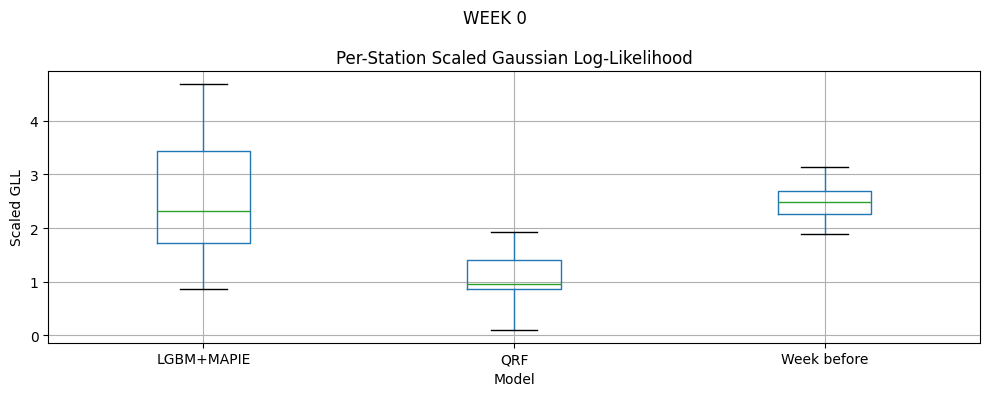

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


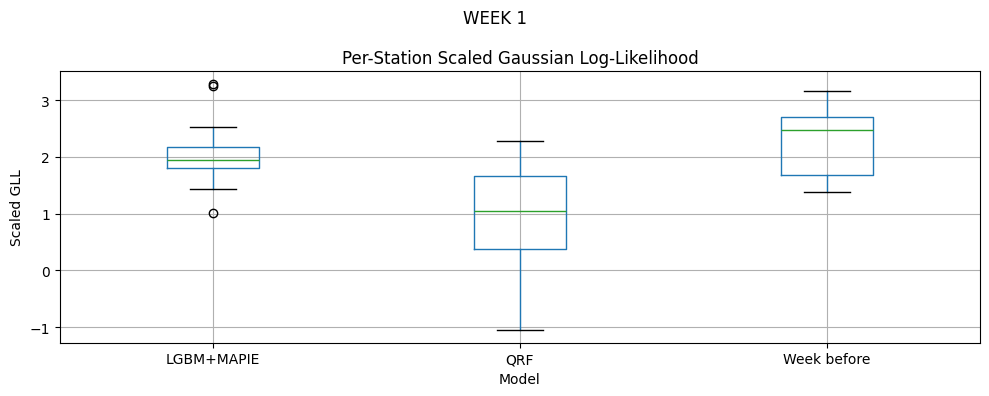

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


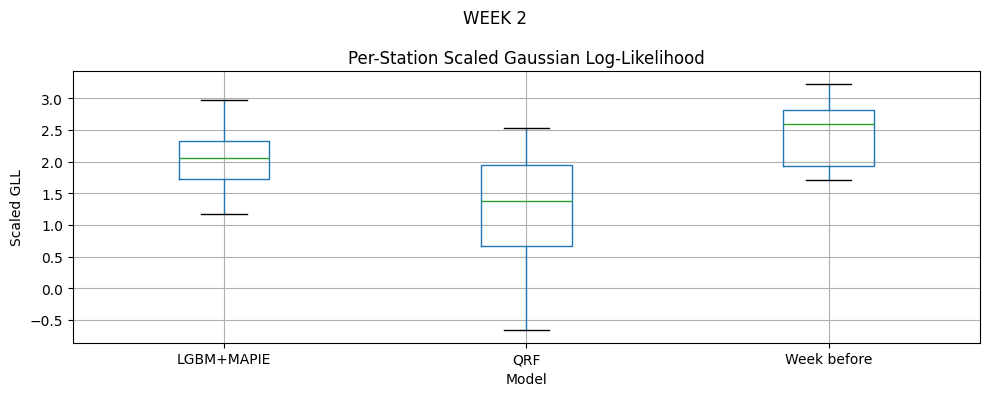

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


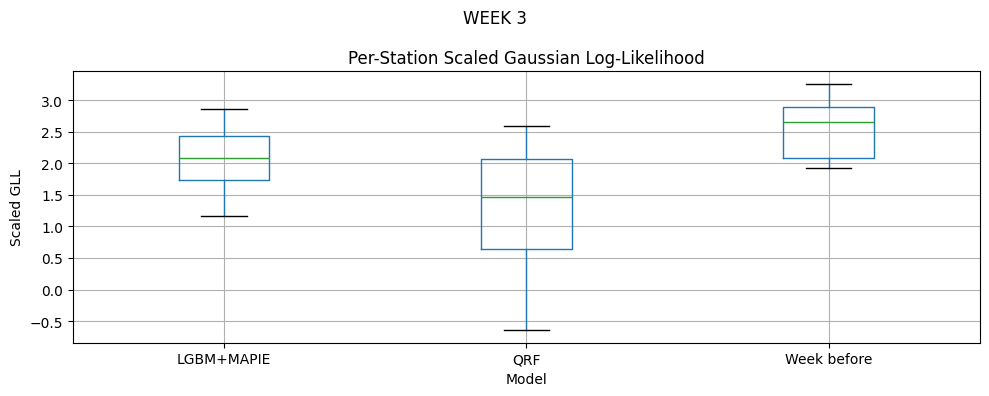

In [12]:
y_train_stations = dataset_train["station_code"].values

X_train_eval = X_train.drop(columns=["station_code"])
for i in range(NUMBER_OF_WEEK):
    predictions = []
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    predictions.append({"model": "Week before", "prediction": baseline_day_before, "dataset":"train", "stations": y_train_stations, "prediction_interval": None})
    if "mapie" in FINAL_MODELS:
        y_pred_mapie, y_pis_mapie = mapie[i].predict(X_train_eval)
        predictions.append({"model": "LGBM+MAPIE",
                            "prediction": y_pred_mapie,
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_mapie})
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(X_train_eval, quantiles="mean", aggregate_leaves_first=False)
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA/2, 1-ALPHA/2])
        predictions.append({"model": "QRF",
                            "prediction": y_pred_qrf,
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_qrf})
    if "lgbm" in FINAL_MODELS:
        y_pred_lgbm = lgbm[i][0.5].predict(X_train_eval)
        y_pis_lgbm = np.stack([lgbm[i][0.05].predict(X_train_eval), 
                       lgbm[i][0.95].predict(X_train_eval)], axis=1)
        predictions.append({"model": "LGBM",
                            "prediction": y_pred_lgbm,
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_lgbm})
    # if "ebm" in FINAL_MODELS:
    #     y_pred_ebm = []
    #     for model in ebm_ensembles[i]:
    #         y_pred_ebm.append(model.predict(X_train_eval))
    #     # list to array
    #     y_pred_ebm = np.array(y_pred_ebm)
    #     intervals = np.percentile(y_pred_ebm, [0, 100], axis=0)
    #     intervals = intervals[:,:].T
    #     y_pred_ebm = np.mean(y_pred_ebm, axis=0)
    #     predictions.append({"model": "EBM",
    #                         "prediction": y_pred_ebm,
    #                         "dataset":"train",
    #                         "stations": y_train_stations,
    #                         "prediction_interval": intervals})
    if "deep_ensemble" in FINAL_MODELS:
        y_pred_deep = []
        for model in deep_ensembles[i]:
            y_pred_deep.append(model.predict(X_train_eval))
        intervals = np.percentile(y_pred_deep, [0, 100], axis=0)
        intervals = intervals[:,:,0].T
        y_pred_deep = np.mean(y_pred_deep, axis=0)
        predictions.append({"model": "Deep Ensemble",
                            "prediction": y_pred_deep[:,0],
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": intervals})
        
    compare_models_per_station(
        y_train[i].values,
        predictions,
        y_train_stations,
        column_to_display="log_likelihood" ,
        title = f"WEEK {i}")

### 4. Coverage on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [14]:
for i in range(NUMBER_OF_WEEK):

    baseline_day_before = dataset_train["water_flow_lag_1w"]
    if "mapie" in FINAL_MODELS:
        y_pred_mapie, y_pis_mapie = mapie[i].predict(X_train_eval)
        coverage = (y_train[i].values >= y_pis_mapie[:,0,0]) & (y_train[i].values <= y_pis_mapie[:,1,0])
        print(f"MAPIE coverage of the prediction interval for week {i}: {coverage.mean()}")
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(X_train_eval, quantiles="mean", aggregate_leaves_first=False)
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA/2, 1-ALPHA/2])
        coverage = (y_train[i].values >= y_pis_qrf[:,0]) & (y_train[i].values <= y_pis_qrf[:,1])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}")
    # if "ebm" in FINAL_MODELS:
    #     y_pred_ebm = []
    #     for model in ebm_ensembles[i]:
    #         y_pred_ebm.append(model.predict(X_train_eval))
    #     y_pred_ebm = np.mean(y_pred_ebm, axis=0)
    #     coverage = (y_train[i].values >= y_pis_qrf[:,0]) & (y_train[i].values <= y_pis_qrf[:,1])
    #     print(f"EBM coverage of the prediction interval for week {i}: {coverage.mean()}")
    if "lgbm" in FINAL_MODELS:
        y_pred_lgbm = lgbm[i][0.5].predict(X_train_eval)
        y_pis_lgbm = np.stack([lgbm[i][0.05].predict(X_train_eval),
                               lgbm[i][0.95].predict(X_train_eval)], axis=1)
        coverage = (y_train[i].values >= y_pis_lgbm[:,0]) & (y_train[i].values <= y_pis_lgbm[:,1])
        print(f"lgbm coverage of the prediction interval for week {i}: {coverage.mean()}")
    if "deep_ensemble" in FINAL_MODELS:
        y_pred_deep = []
        for model in deep_ensembles[i]:
            y_pred_deep.append(model.predict(X_train_eval))
        intervals = np.percentile(y_pred_deep, [0, 100], axis=0)
        intervals = intervals[:,:,0].T
        coverage = (y_train[i].values >= intervals[:,0]) & (y_train[i].values <= intervals[:,1])
        print(f"Deep Ensemble coverage of the prediction interval for week {i}: {coverage.mean()}")


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


MAPIE coverage of the prediction interval for week 0: 0.9585950472890044
QRF coverage of the prediction interval for week 0: 0.9653454624214858


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


MAPIE coverage of the prediction interval for week 1: 0.9490289509782687
QRF coverage of the prediction interval for week 1: 0.9665728106273915


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


MAPIE coverage of the prediction interval for week 2: 0.9434336870984045
QRF coverage of the prediction interval for week 2: 0.9649844776550429


c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


MAPIE coverage of the prediction interval for week 3: 0.9451303155006858
QRF coverage of the prediction interval for week 3: 0.9659591365244387
